In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()

In [81]:
from matplotlib.ticker import FixedLocator, FixedFormatter
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from sklearn.metrics import silhouette_samples
from sklearn.metrics import silhouette_score
from sklearn.mixture import BayesianGaussianMixture
from sklearn.mixture import GaussianMixture

### Data preparation

In [6]:
# loading genotypic data
geno = pd.read_csv("ac_pop_geno.txt", sep="\t", header=None, na_values=-1)
geno = geno.drop([1],axis=1)
geno = geno.set_index(0)

In [7]:
geno

,2,3,4,5,6,7,8,9,10,11,...,1894,1895,1896,1897,1898,1899,1900,1901,1902,1903
0,,,,,,,,,,,,,,,,,,,,,
AC_2013_1_finland,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,NaN,0.0,...,2.0,2.0,0.0,0.0,NaN,1.0,0.0,2.0,0.0,2.0
AC_2013_2_finland,0.0,0.0,0.0,2.0,0.0,0.0,0.0,NaN,1.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
AC_2013_3_finland,0.0,NaN,0.0,2.0,NaN,NaN,2.0,NaN,NaN,0.0,...,2.0,1.0,0.0,0.0,NaN,1.0,0.0,NaN,0.0,0.0
AC_2013_4_finland,0.0,1.0,0.0,2.0,NaN,0.0,NaN,2.0,1.0,0.0,...,2.0,2.0,0.0,0.0,NaN,1.0,0.0,1.0,0.0,0.0
AC_2013_5_finland,0.0,0.0,0.0,2.0,0.0,0.0,2.0,2.0,1.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AC_yc2013_246_sweden,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0
AC_yc2013_247_sweden,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,2.0,0.0,0.0,2.0,1.0,1.0,2.0
AC_yc2013_248_sweden,0.0,1.0,1.0,0.0,0.0,2.0,0.0,1.0,0.0,2.0,...,1.0,0.0,1.0,0.0,0.0,2.0,2.0,0.0,1.0,2.0


In [8]:
# imputes missing values using KNN
X = geno.values
imputer = KNNImputer(n_neighbors=3)
X_imp = imputer.fit_transform(X)
X_imp

array([[0., 0., 0., ..., 2., 0., 2.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 1., ..., 0., 1., 2.],
       [0., 2., 0., ..., 2., 0., 2.],
       [0., 2., 0., ..., 0., 1., 0.]])

In [9]:
# population labels
pop_labels = pd.read_csv("ac_scandinavia_map_filt.txt", sep="\t")
pop_labels

,id,pop
0,AC_2013_1_finland,Finland
1,AC_2013_2_finland,Finland
2,AC_2013_3_finland,Finland
3,AC_2013_4_finland,Finland
4,AC_2013_5_finland,Finland
...,...,...
487,AC_yc2013_246_sweden,Sweden
488,AC_yc2013_247_sweden,Sweden
489,AC_yc2013_248_sweden,Sweden
490,AC_yc2013_249_sweden,Sweden


In [10]:
# changing text labels to numbers
pop_map = {"Finland":1, "Norway":2, "Sweden":3}
y = pop_labels["pop"].replace(pop_map).values
y

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

### Fitting a Gaussian Mixture model

In [11]:
gm_n = [GaussianMixture(n_components=k, n_init=10).fit(X_imp) for k in range(1,6)]

In [12]:
for i,_ in enumerate(gm_n):
    print("Components=",i+1," AIC=",gm_n[i].aic(X_imp)," BIC=",gm_n[i].bic(X_imp))

Components= 1  AIC= -4206153.801859341  BIC= 3400041.1572675304
Components= 2  AIC= -2005506.309586268  BIC= 13206887.807146192
Components= 3  AIC= 877811.7623191997  BIC= 23696405.03665725
Components= 4  AIC= 4304752.359900158  BIC= 34729544.7918438
Components= 5  AIC= 7741433.751635164  BIC= 45772425.34118439


### Fitting a Bayesian Gausian Mixture model

In [22]:
bgm = BayesianGaussianMixture(n_components=5, n_init=10).fit(X_imp)

In [23]:
bgm.weights_

array([0.16835319, 0.33791096, 0.32645702, 0.11748279, 0.04979604])

### Dimensionality reduction - PCA

In [72]:
pca = PCA(n_components=2)

In [73]:
X_reduced = pca.fit_transform(X_imp)

#### Bayesian Gausian Mixture PCA

In [26]:
bgm_pca = BayesianGaussianMixture(n_components=5, n_init=10).fit(X_reduced)

In [27]:
bgm_pca.weights_

array([3.38608805e-01, 3.35552535e-01, 3.25448023e-01, 3.34831833e-04,
       5.58050342e-05])

#### Gaussian Mixture PCA

In [28]:
gm_n_pca = [GaussianMixture(n_components=k, n_init=10).fit(X_reduced) for k in range(1,6)]

In [29]:
for i,_ in enumerate(gm_n_pca):
    print("Components=",i+1," AIC=",gm_n_pca[i].aic(X_reduced)," BIC=",gm_n_pca[i].bic(X_reduced))

Components= 1  AIC= 7857.596792529736  BIC= 7878.589186112198
Components= 2  AIC= 4210.400031579872  BIC= 4256.583297461288
Components= 3  AIC= 2815.1730085316167  BIC= 2886.547146711986
Components= 4  AIC= 2816.3460871061907  BIC= 2912.9110975855137
Components= 5  AIC= 2822.3224655866725  BIC= 2944.0783483649493


### K-Means

In [30]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42, n_init=10).fit(X_imp)
                for k in range(2, 6)]

In [31]:
kmeans_per_k

[KMeans(n_clusters=2, n_init=10, random_state=42),
 KMeans(n_clusters=3, n_init=10, random_state=42),
 KMeans(n_clusters=4, n_init=10, random_state=42),
 KMeans(n_clusters=5, n_init=10, random_state=42)]

In [65]:
for i in range(2,6):
    kmeans = KMeans(n_clusters=i, n_init=10)
    kmeans.fit(X_imp)
    print("K=",i,"Silhouette score=",silhouette_score(X_imp, kmeans.labels_))


K= 2 Silhouette score= 0.30327797079254787
K= 3 Silhouette score= 0.31910883315178196
K= 4 Silhouette score= 0.1900125575393633
K= 5 Silhouette score= 0.10464258258239467


In [77]:
def silhouette_plot(X, k_num, file_name):
    """
    Silhouette plot for four different KMeans models
    The genotypic matrix X should not contain any missing values
    k_num should be a range object
    """
    fig = plt.figure(figsize=(10,5))
    
    silhouette_scores = []

    for k in range(k_num.start, k_num.stop):
        plt.subplot(2, 2, k - 1)
        
        kmeans_per_k = KMeans(n_clusters=k, random_state=42, n_init=10).fit(X)
        y = kmeans_per_k.labels_ 
        silhouette_coefficients = silhouette_samples(X, y)
        silhouette_scores.append(silhouette_score(X, y))

        padding = len(X) // 30
        pos = padding
        ticks = []
        for i in range(k):
            coeffs = silhouette_coefficients[y == i]
            coeffs.sort()

            color = plt.cm.Spectral(i / k)
            plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
            ticks.append(pos + len(coeffs) // 2)
            pos += len(coeffs) + padding

        plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
        plt.gca().yaxis.set_major_formatter(FixedFormatter(range(1,k+1)))
        if k in (k_num.start, k_num.start + 2):
            plt.ylabel("Cluster")
    
        if k in (k_num.start + 2, k_num.stop - 1):
            plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
            plt.xlabel("Silhouette Coefficient")
        else:
            plt.tick_params(labelbottom=True)

        plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
        plt.title(f"$k={k}$")

    plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)       

    plt.show()
    fig.savefig(file_name)


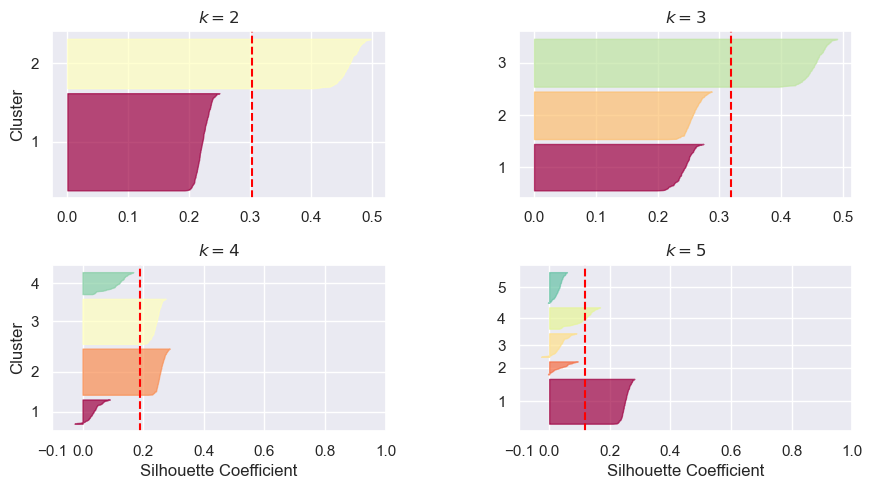

In [78]:
silhouette_plot(X=X_imp, k_num=range(2,6), file_name="silhouette_kmeans.pdf")

### KMeans after dimensionality reduction

In [79]:
for i in range(2,6):
    kmeans = KMeans(n_clusters=i, n_init=10)
    kmeans.fit(X_reduced)
    print("K=",i,"Silhouette score=",silhouette_score(X_reduced, kmeans.labels_))


K= 2 Silhouette score= 0.7333246533019092
K= 3 Silhouette score= 0.9601947636850754
K= 4 Silhouette score= 0.7897974888614406
K= 5 Silhouette score= 0.6285953094795966


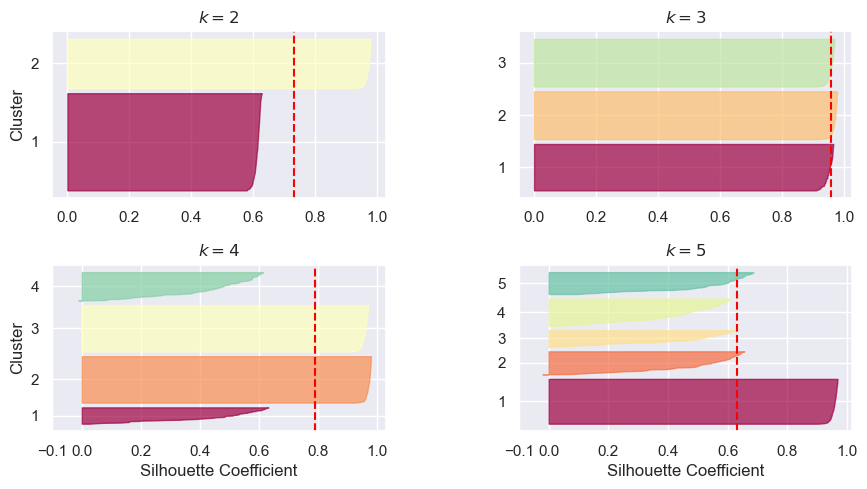

In [80]:
silhouette_plot(X=X_reduced, k_num=range(2,6), file_name="silhouette_kmeans_reduced.pdf")